In [1]:
import torch
from fastai.vision.all import *
import timm
import rasterio as rio
import pandas as pd
from pathlib import Path
from functools import partial
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
from safetensors.torch import save_file
from fastai.metrics import JaccardCoeffMulti, JaccardCoeff
from types import SimpleNamespace
from distance_transform_optimized import distance_transform_torch as distance_transform
from torch.nn import CrossEntropyLoss


In [2]:
from augs import (
    BatchRot90,
    # RandomRectangle,
    DynamicZScoreNormalize,
    # SceneEdge,
    # BatchTear,
    BatchResample,
    RandomClipLargeImages,
    # RandomSharpenBlur,
    # ClipHighAndLow,
    QuantizeBatchSize,
    BatchFlip,
)


In [3]:
from helpers import plot_batch, show_histo, print_system_info

print_system_info()


System Information
-----------------------------------
PyTorch Version : 2.9.1+cu128
CUDA Available  : Yes
CUDA Version    : 12.8
Python Version  : 3.13.7
Fastai Version  : 2.8.6
Default Device  : cuda:0
Device Name     : NVIDIA GeForce RTX 4090
-----------------------------------


In [4]:
model_provider = "smp"
# model_provider = "fastai"

In [5]:
# model_type = "regnety_004.pycls_in1k"
model_type = "regnety_002.pycls_in1k"

# model_type = "edgenext_small.usi_in1k"
# model_type = "edgenext_x_small.usi_in1k"
# model_type = "edgenext_xx_small.usi_in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"
# model_type = "convnextv2_pico.fcmae_ft_in1k"
# model_type = "convnextv2_femto.fcmae_ft_in1k"
# model_type = "convnextv2_atto.fcmae_ft_in1k"

# model_type = "convnextv2_nano.fcmae_ft_in1k"  # 16 Pretty good
# model_type = "convnextv2_tiny.fcmae_ft_in22k_in1k_384"
# model_type = "convnextv2_base.fcmae_ft_in22k_in1k_384"  # 2 best

In [6]:
flair_training_data_dir = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches"
)
s1s2_training_data_dir = Path("/media/nick/4TB Working 6/Datasets/S1S2-Water/train")


In [7]:
sources = [flair_training_data_dir, s1s2_training_data_dir]
sources

[Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches'),
 Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')]

In [8]:
flair_water_only_csv_path = Path(
    "/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR_patches_with_water.csv"
)

In [9]:
model_base_name = "2.0.3"

In [10]:
max_clip_image_size = 500
min_clip_image_size = 256

In [11]:
only_water_flair = True

labels_folder_name = "labels"

batch_size = 32
GA_batch_size = 256

epoch_count = 15

learning_rate = 0.0001

class_loss_weights = [1, 2]

# initial image size
original_image_size = 512
# bf16 if faster uses less memory then fp32 and is more stable than fp16
bf16 = True
class_count = 2
validation_sample_frac = (
    0.1  # the s1s2 validation set is large so we only use a small fraction of it
)
# training_sample_frac = 0.1
training_sample_frac = 1.0

In [12]:
name_addition = "_S1S2"
name_addition += "_L2A"

name_addition += "_flair"
if only_water_flair:
    name_addition += "_only_water"


model_full_name = f"{model_base_name}{name_addition}_{model_type.split('.')[0]}"
model_full_name

'2.0.3_S1S2_L2A_flair_only_water_regnety_002'

In [13]:
s1s2_limited_band_read_list = [3, 2, 1, 4]  # Red, Green, Blue, NIR,
flair_limited_band_read_list = [1, 2, 3, 4]  # Red, Green, Blue, NIR

In [14]:
if only_water_flair:
    flair_water_df = pd.read_csv(flair_water_only_csv_path)
    water_flair_imgs = flair_water_df["image_path"].values
    water_flair_imgs = [Path(img) for img in water_flair_imgs]
    print(len(water_flair_imgs))
    water_flair_imgs = set(water_flair_imgs)

16884


In [15]:
def get_image_files_custom(sources):
    all_train_images = []
    all_val_images = []

    for source in sources:
        images_dir = source / "images"
        assert images_dir.exists(), f"Images dir {images_dir} does not exist"

        if source == s1s2_training_data_dir:
            train_images = list(images_dir.glob("*train*.tif"))
            val_images = list(images_dir.glob("*val*.tif"))
            original_val_count = len(val_images)
            print(f"Found {original_val_count} S1S2 validation images")
            val_images = random.sample(
                val_images, int(original_val_count * validation_sample_frac)
            )
            print(f"Using {len(val_images)} S1S2 validation images")

        elif source == flair_training_data_dir:
            val_images = []
            if only_water_flair:
                train_images = list(water_flair_imgs)
            else:
                train_images = list(images_dir.glob("*train*.tif"))

        else:
            raise ValueError(f"Unknown source {source}")

        print(f"Found {len(train_images)} training images from {source}")
        print(f"Found {len(val_images)} validation images from {source}")

        all_train_images += train_images
        all_val_images += val_images
    if training_sample_frac < 1:
        print(f"But only using {training_sample_frac} of them")
        # take random sample of the data
        all_train_images = random.sample(
            all_train_images, int(len(all_train_images) * training_sample_frac)
        )

    print(f"Total training images: {len(all_train_images)}")
    print(f"Total validation images: {len(all_val_images)}")
    return all_train_images + all_val_images


In [16]:
_ = get_image_files_custom(sources)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21628 S1S2 validation images
Using 2162 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2162 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2162


In [17]:
def label_func(file_path):
    file_name = file_path.name
    normalised_name = file_name.replace("_L2A", "")
    label_path = file_path.parent.parent / "labels" / normalised_name

    return label_path


def is_valid_file(x):
    if "val" in x.name:
        return True
    return False

In [18]:
train_and_val_images = get_image_files_custom(sources)
for image in tqdm(train_and_val_images):
    label_path = label_func(image)
    assert label_path.exists(), f"{label_path} does not exist from image {image}"
len(train_and_val_images)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21628 S1S2 validation images
Using 2162 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2162 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2162


  0%|          | 0/63662 [00:00<?, ?it/s]

63662

In [19]:
train_and_val_images[0].parents[1]

Path('/media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches')

In [20]:
s1s2_training_data_dir


Path('/media/nick/4TB Working 6/Datasets/S1S2-Water/train')

In [21]:
def open_img(
    img_path: Path,
    img_size: int,
    bf16: bool,
) -> TensorImage:
    with rio.open(img_path) as src:
        if img_path.parents[1] == flair_training_data_dir:
            limited_band_read_list = flair_limited_band_read_list
        elif img_path.parents[1] == s1s2_training_data_dir:
            limited_band_read_list = s1s2_limited_band_read_list
        else:
            raise ValueError("Unknown training data dir")
        raw_bands = src.read(
            limited_band_read_list,
            out_shape=(img_size, img_size),
            resampling=rio.enums.Resampling.average,  # type: ignore
        ).astype(np.float32)

    image_tensor = torch.from_numpy(raw_bands)

    if bf16:
        image_tensor = image_tensor.bfloat16()

    return TensorImage(image_tensor)

In [22]:
open_img(train_and_val_images[0], original_image_size, bf16).shape

torch.Size([4, 512, 512])

In [23]:
# label_func_partial = partial(label_func, labels_dir)

open_img_no_cache_partial = partial(open_img, img_size=original_image_size, bf16=True)

In [24]:
blocks = (
    TransformBlock([open_img_no_cache_partial]),
    MaskBlock(codes=[0, 1]),
)

In [25]:
dblock = DataBlock(
    blocks=blocks,  # type: ignore
    get_items=get_image_files_custom,  # type: ignore
    get_y=label_func,  # type: ignore
    splitter=FuncSplitter(lambda x: is_valid_file(x)),  # type: ignore
    batch_tfms=[  # type: ignore
        IntToFloatTensor(1, 1),
        BatchFlip(),
        BatchRot90(),
        DynamicZScoreNormalize(),
        BatchResample(min_scale=0.2, max_scale=1.111),
        RandomClipLargeImages(  # Clips large images to a random size
            max_size=max_clip_image_size, min_size=min_clip_image_size
        ),
        QuantizeBatchSize(min_size=100, max_size=max_clip_image_size),
    ],
)

In [26]:
dl = dblock.dataloaders(
    size=original_image_size,
    source=sources,
    bs=batch_size,
    num_workers=16,
    pin_memory=True,
)

Found 16884 training images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 0 validation images from /media/nick/4TB Working 6/Datasets/FLAIR_retrain/train/FLAIR patches
Found 21628 S1S2 validation images
Using 2162 S1S2 validation images
Found 44616 training images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Found 2162 validation images from /media/nick/4TB Working 6/Datasets/S1S2-Water/train
Total training images: 61500
Total validation images: 2162


In [27]:
batch = dl.one_batch()
batch[0].shape

torch.Size([32, 4, 200, 200])

In [28]:
num_input_channels = batch[0].shape[1]
num_input_channels

4

In [29]:
band_labels = ["B04", "B03", "B02", "B08", "Slope"]
# band_labels = ["B03", "B08"]


band_labels

['B04', 'B03', 'B02', 'B08', 'Slope']

Image tensor shape: torch.Size([32, 4, 200, 200])
Label shape: torch.Size([32, 200, 200])


/home/nick/Documents/Work code/OmniWaterMask-training/helpers.py:37: RuntimeWarning: invalid value encountered in divide
  rgb_img = (rgb_img - rgb_img.min()) / (


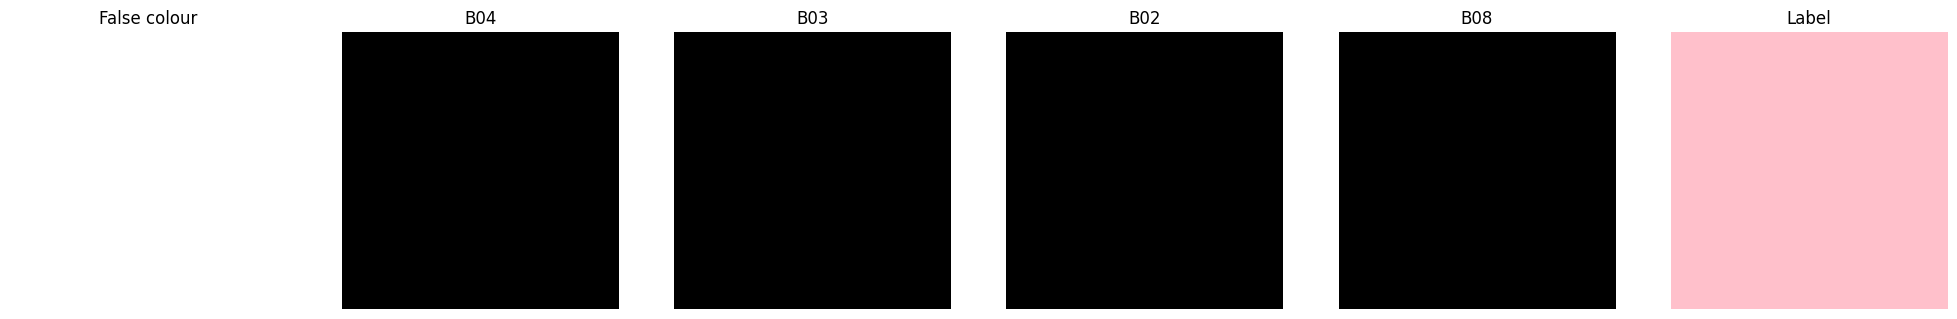

In [30]:
plot_batch(batch, labels=["False colour"] + band_labels)

In [31]:
batch[0][0][0].mean()

TensorImage(0., device='cuda:0')

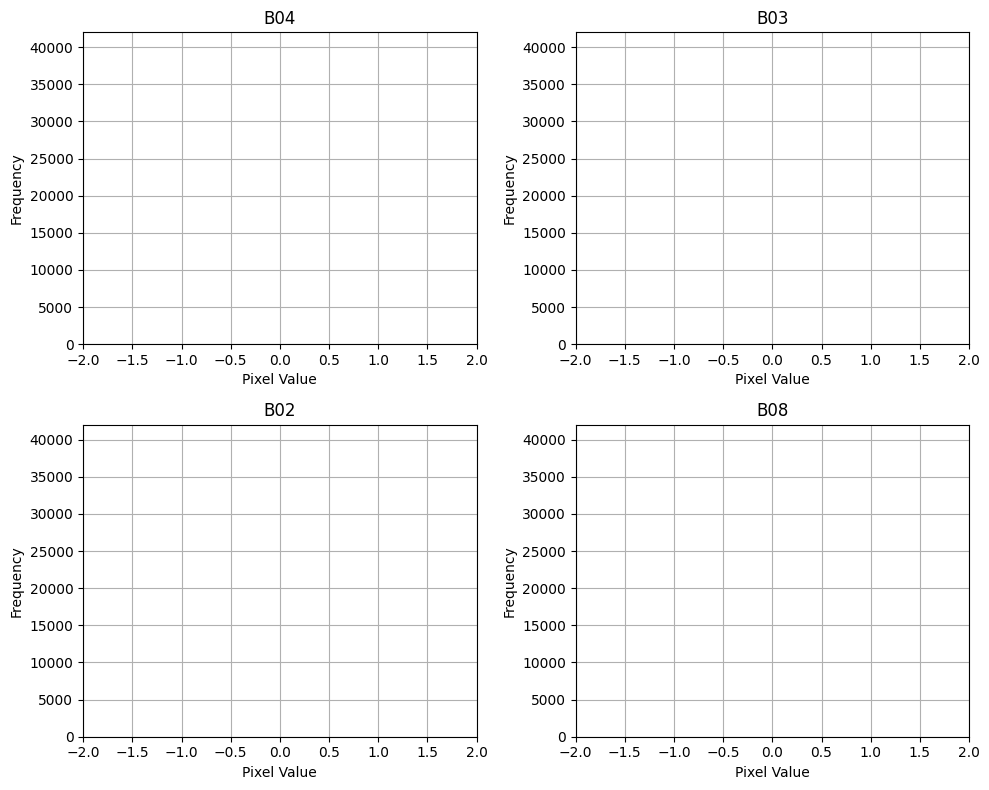

In [32]:
show_histo(batch, labels=band_labels)

In [33]:
batch[0].shape[1]

4

In [34]:
fai_model_name = f"PM_model_{model_full_name}_fai"
pytorch_model_name = f"PM_model_{model_full_name}_PT.pth"
pytorch_model_path = Path.cwd() / "models" / pytorch_model_name
state_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.pth"
safetensor_state_path = (
    pytorch_model_path.parent / f"{pytorch_model_path.stem}_state.safetensors"
)
config_path = pytorch_model_path.parent / f"{pytorch_model_path.stem}_config.json"
if pytorch_model_path.exists():
    raise ValueError("Model already exists", pytorch_model_name)
if state_path.exists():
    raise ValueError("State path already exists")
if safetensor_state_path.exists():
    raise ValueError("Safetensor state path already exists")
if config_path.exists():
    raise ValueError("Config path already exists")

print(f"Fastai model {fai_model_name}")
print(f"PyTorch model {pytorch_model_name}")
print(f"State path: {state_path}")
print(f"Safetensor state path: {safetensor_state_path}")


Fastai model PM_model_2.0.3_S1S2_L2A_flair_only_water_regnety_002_fai
PyTorch model PM_model_2.0.3_S1S2_L2A_flair_only_water_regnety_002_PT.pth
State path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.3_S1S2_L2A_flair_only_water_regnety_002_PT_state.pth
Safetensor state path: /home/nick/Documents/Work code/OmniWaterMask-training/models/PM_model_2.0.3_S1S2_L2A_flair_only_water_regnety_002_PT_state.safetensors


In [35]:
if pytorch_model_path.exists():
    raise ValueError("Model already exists")

In [36]:
torch.tensor(class_loss_weights).float().cuda()

tensor([1., 2.], device='cuda:0')

In [37]:
ignore_index = 99
cel = CrossEntropyLoss(
    reduction="none",
    weight=torch.tensor(class_loss_weights).float().cuda(),
    ignore_index=ignore_index,
)


def combo_loss(pred, target):
    # apply distance transform and set valid mask
    pixel_weight = distance_transform(target, clip_distance=3)
    pixel_cel = cel(pred, target)
    return (pixel_cel * pixel_weight).mean()


# metrics = [JaccardCoeffMulti(axis=1), JaccardCoeff(axis=1)]

In [38]:
class IgnoreIndexMetric(Metric):
    """Wrapper that filters out ignore_index pixels before computing metric"""

    def __init__(self, metric, ignore_index=99):
        self.metric = metric
        self.ignore_index = ignore_index

    @property
    def name(self):
        return self.metric.name

    def reset(self):
        self.metric.reset()

    @property
    def value(self):
        return self.metric.value

    def accumulate(self, learn):
        mask = learn.y != self.ignore_index
        if not mask.any():
            return

        # Flatten spatial dims, filter by mask, reshape for metric
        # pred: [B, C, H, W] -> [N_valid, C] -> [1, C, N_valid]
        # y: [B, H, W] -> [N_valid] -> [1, N_valid]
        pred_filtered = learn.pred.permute(0, 2, 3, 1)[mask].T.unsqueeze(0)
        y_filtered = learn.y[mask].unsqueeze(0)

        # Create mock learn object with filtered data
        mock_learn = SimpleNamespace(pred=pred_filtered, y=y_filtered)
        self.metric.accumulate(mock_learn)


metrics = [
    IgnoreIndexMetric(JaccardCoeffMulti(axis=1), ignore_index=99),
    IgnoreIndexMetric(JaccardCoeff(axis=1), ignore_index=99),
]


In [39]:
save_metric = "valid_loss"

In [40]:
callbacks = [
    SaveModelCallback(monitor=save_metric, fname=fai_model_name, with_opt=True),
    ShowGraphCallback(),
    GradientAccumulation(GA_batch_size),
]

In [41]:
if model_provider == "fastai":
    print(f"Using fastai model: {model_type}")
    timm_model = partial(
        timm.create_model,
        model_type,
        pretrained=True,
        in_chans=num_input_channels,
    )
    model = create_unet_model(
        img_size=(original_image_size, original_image_size),
        arch=timm_model,
        n_out=class_count,
        pretrained=True,
        act_cls=torch.nn.Mish,
    )
elif model_provider == "smp":
    print(f"Using segmentation_models_pytorch model: {model_type}")
    model = smp.Unet(
        encoder_name=f"tu-{model_type.split('.')[0]}",
        encoder_weights="imagenet",
        in_channels=num_input_channels,
        classes=class_count,
    )

else:
    raise ValueError(f"Unknown model provider: {model_provider}")


Using segmentation_models_pytorch model: regnety_002.pycls_in1k


In [42]:
dummy_input = torch.randn(
    1, num_input_channels, original_image_size, original_image_size
)
model_output = model(dummy_input)
assert model_output.shape == (
    1,
    class_count,
    original_image_size,
    original_image_size,
), "Model output shape mismatch"


In [44]:
learner = Learner(
    dls=dl,
    model=model,
    loss_func=combo_loss,
    metrics=metrics,
    cbs=callbacks,
)


In [45]:
if bf16:
    print("Using BF16")
    learner = learner.to_bf16()

print(f"Using learning rate: {learning_rate}, with model {model_type}")

Using BF16
Using learning rate: 0.0001, with model regnety_002.pycls_in1k


epoch,train_loss,valid_loss,jaccard_coeff_multi,jaccard_coeff,time
0,0.355439,0.295783,0.786000,0.632856,04:20


Better model found at epoch 0 with valid_loss value: 0.29578304290771484.


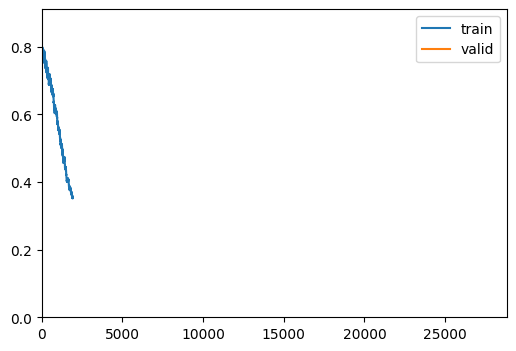

In [ ]:
learner.fit_one_cycle(
    n_epoch=epoch_count,
    lr_max=learning_rate,
)


In [ ]:
# reload the model to get the best one
learner.load(fai_model_name)

In [ ]:
# extract model from learner and move to cpu
model = learner.model.to("cpu")
model = model.float()

In [ ]:
torch.save(model, pytorch_model_path)
pytorch_model_path

In [ ]:
torch.save(model.state_dict(), state_path)
state_path

In [ ]:
save_file(model.state_dict(), safetensor_state_path)
safetensor_state_path